## A simple use case - prediciting Amazon stock prices using the randomized signature of correlated paths

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from timeit import default_timer as timer
import math
import pandas as pd
from datetime import datetime
from datetime import date

In [4]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

sigm_v = np.vectorize(sigmoid)

def scaling(d, M):
    r = 1
    for i in range(d):
        r += M ** (i+1)
    return r

In [5]:
def process_df(path):
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    start = date.fromisoformat('2022-06-24')
    end = date.fromisoformat('2023-06-23')
    new_dates = pd.date_range(start=start,end=end,freq='D')
    df = df.reindex(new_dates)
    assert( len(df) == 365 )
    df["Open"] = df["Open"].interpolate()
    df["Open"] =( df["Open"] - df["Open"].mean() ) / df["Open"].std()
    return(df["Open"])

## Import, clean and preprocess finance data

In [6]:
file_paths = [r'datasets\cov_^N225.csv', r'datasets\cov_^NDX.csv', r'datasets\cov_^NYA.csv',
             r'datasets\cov_^SPX.csv', r'datasets\cov_^TNX.csv', r'datasets\cov_^VIX.csv',
             r'datasets\cov_^XAU.csv', r'datasets\cov_^XOI.csv', r'datasets\cov_000300.SS.csv',
             r'datasets\cov_BTC-USD.csv', r'datasets\cov_CGW.csv', r'datasets\cov_DAX.csv',
             r'datasets\cov_EURUSD=X.csv', r'datasets\cov_FEZ.csv', r'datasets\cov_GBPUSD=X.csv',
              r'datasets\cov_INDEX.csv', r'datasets\cov_MME=F.csv', r'datasets\cov_USDJPY=X.csv', 
              r'datasets\cov_VGSLX.csv', r'datasets\cov_VTI.csv'
             ]
amazon_file_path = r'datasets\target_AMZN.csv'
len(file_paths)

20

In [7]:
df_amzn = pd.read_csv(amazon_file_path)

In [8]:
df_amzn['Date'] = pd.to_datetime(df_amzn['Date'])

In [9]:
df_amzn = df_amzn.set_index('Date')

In [10]:
start = date.fromisoformat('2022-06-24')
end = date.fromisoformat('2023-06-23')

In [11]:
new_dates = pd.date_range(start=start,end=end,freq='D')
df_amzn = df_amzn.reindex(new_dates)

In [12]:
assert( len(df_amzn) == 365 )
df_amzn["Open"] = df_amzn["Open"].interpolate()
df_amzn["Open"] =( df_amzn["Open"] - df_amzn["Open"].mean() ) / df_amzn["Open"].std()
df_amzn.rename(columns={"Open": "amzn"})

df_amzn["amzn"] = df_amzn["Open"]

df_amzn = df_amzn.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])

df_amzn

,amzn
2022-06-24,0.254158
2022-06-25,0.355996
2022-06-26,0.457834
2022-06-27,0.559671
2022-06-28,0.326807
...,...
2023-06-19,1.115239
2023-06-20,1.070807
2023-06-21,1.114266
2023-06-22,1.092861


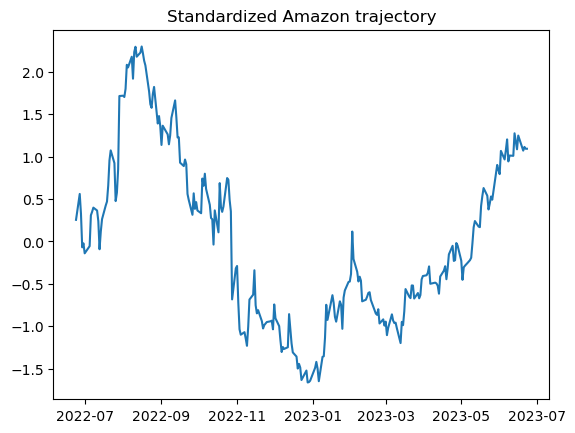

In [13]:
plt.plot(df_amzn.index,df_amzn['amzn'])
plt.title("Standardized Amazon trajectory")
plt.show()

In [14]:
path = file_paths[0]
path

'datasets\\cov_^N225.csv'

In [15]:
process_df(path)

2022-06-24   -1.113145
2022-06-25   -1.005608
2022-06-26   -0.898071
2022-06-27   -0.790535
2022-06-28   -0.756677
                ...   
2023-06-19    3.625187
2023-06-20    3.311538
2023-06-21    3.268215
2023-06-22    3.417387
2023-06-23    3.430168
Freq: D, Name: Open, Length: 365, dtype: float64

In [16]:
i = 1
for path in file_paths:
    df_amzn['cov' + str(i)] = process_df(path)
    i+=1

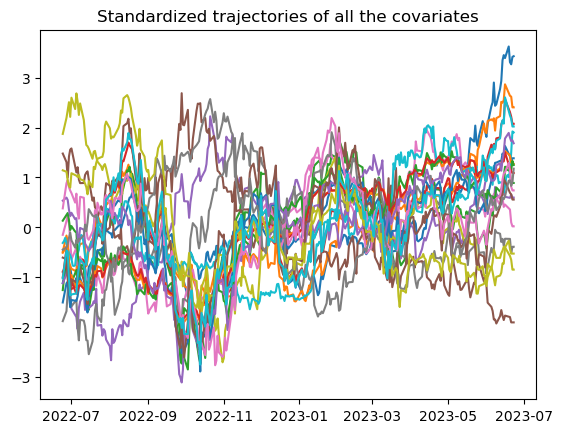

In [17]:
for i in range(1, 21):
    plt.plot(df_amzn.index, df_amzn['cov' + str(i)])
plt.title("Standardized trajectories of all the covariates")
plt.show()

## Switch to generic vector representation

In [18]:
amzn_array = df_amzn['amzn'].to_numpy()
amzn_array.shape

(365,)

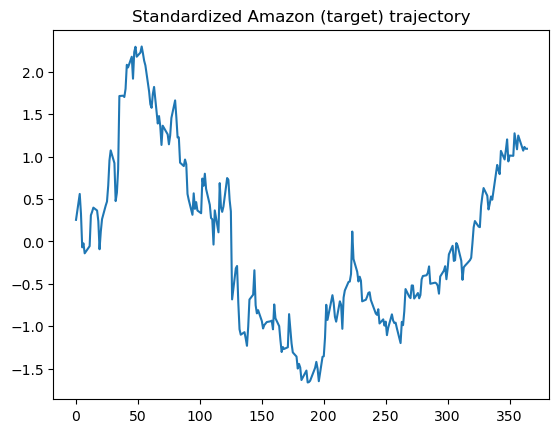

In [41]:
plt.plot(amzn_array)
plt.title("Standardized Amazon (target) trajectory")
plt.show()

In [42]:
cov_array = np.zeros((365, 20))
for i in range(1, 21):
    cov_array[:,i-1] = df_amzn['cov' + str(i)].to_numpy()

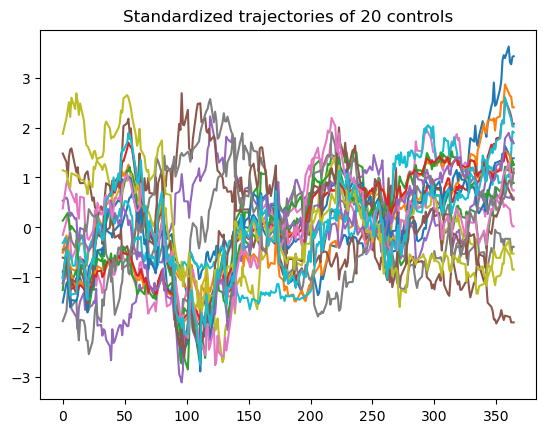

In [272]:
for i in range(1, 21):
    plt.plot(cov_array[:,i-1])
plt.title("Standardized trajectories of 20 controls")
plt.show()

## Compute a lower-dimensional randomized signature of the covariate process

In [229]:
k = 2000
A = np.random.normal(0, 1, size=(20, k, k))
b = np.random.normal(0, 1, size=(20,k))
dcov = np.diff(cov_array, axis = 0)
Z = np.zeros((365, k))
Z[0][0] = 1

In [230]:
for i in range(364):
    auxiliary = 0
    for j in range(20):
        auxiliary += (1/10)*sigm_v(A[j]@Z[i] + b[j])*dcov[i][j]
    Z[i+1] = Z[i] + auxiliary

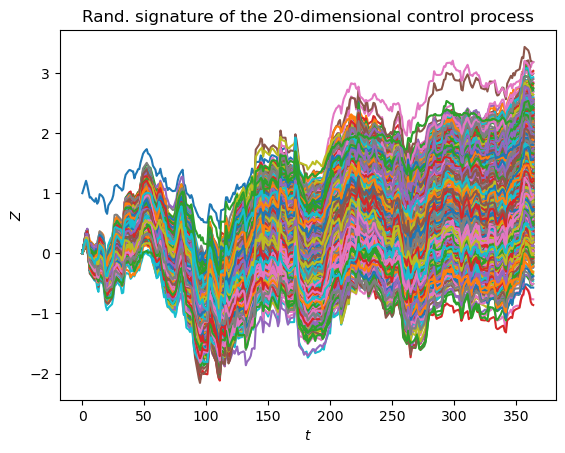

In [231]:
for i in range(k):
    plt.plot(Z[:,i])

plt.title("Rand. signature of the 20-dimensional control process")
plt.xlabel("$t$")
plt.ylabel("$Z$")
plt.show()

## Use to signature to approximate the price of Amazon

#### With cross-validation

In [273]:
days_for_training, days_for_cv = 330, 15

In [274]:
model1 = Ridge(alpha=5).fit(Z[:days_for_training,], amzn_array[:days_for_training,])

In [275]:
r_sq_1 = model1.score(Z[:days_for_training,], amzn_array[:days_for_training,])
print(f"coefficient of determination: {r_sq_1}")

coefficient of determination: 0.9929602104134649


In [276]:
print(f"intercept: {model1.intercept_}")

intercept: 0.2735298835653789


In [277]:
#print(f"coefficients: {model1.coef_}")

In [278]:
amzn_pred_1 = model1.predict(Z)

In [279]:
range(30,200)

range(30, 200)

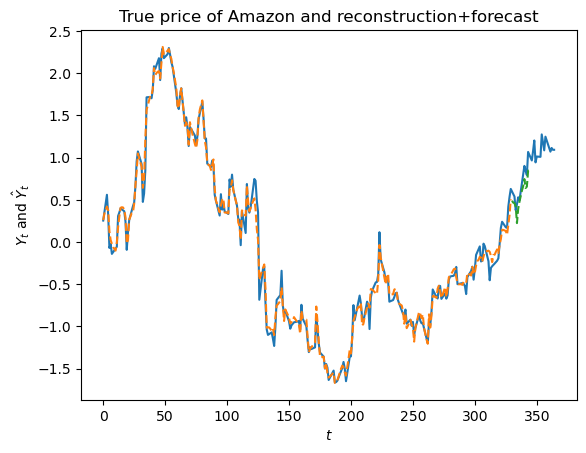

In [280]:
plt.plot(range(365),amzn_array)
plt.plot(range(days_for_training),amzn_pred_1[0:days_for_training], '--')
plt.plot(range(days_for_training,days_for_training + days_for_cv),amzn_pred_1[days_for_training:days_for_training + days_for_cv], '--')
plt.title("True price of Amazon and reconstruction+forecast")
plt.xlabel("$t$")
plt.ylabel("$Y_t$ and $\hat{Y}_t$")
plt.show()

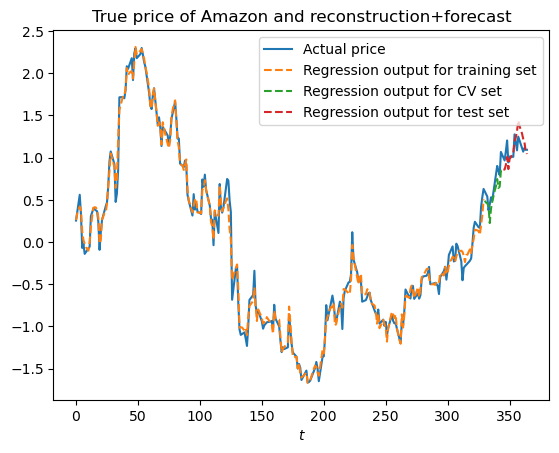

In [281]:
plt.plot(range(365),amzn_array)
plt.plot(range(days_for_training),amzn_pred_1[0:days_for_training], '--')
plt.plot(range(days_for_training,days_for_training + days_for_cv),amzn_pred_1[days_for_training:days_for_training + days_for_cv], '--')
plt.plot(range(days_for_training + days_for_cv, 365) ,amzn_pred_1[days_for_training + days_for_cv:], '--')
plt.title("True price of Amazon and reconstruction+forecast")
plt.xlabel("$t$")
plt.gca().legend(('Actual price','Regression output for training set', 'Regression output for CV set', 'Regression output for test set'))
plt.show()

In [282]:
np.linalg.norm(amzn_array[days_for_training + days_for_cv:]-amzn_pred_1[days_for_training + days_for_cv:])/np.linalg.norm(amzn_array[days_for_training + days_for_cv:])

0.11589058387224227

In [283]:
amzn_pred_1_series = pd.Series(amzn_pred_1)
amzn_pred_1_series = amzn_pred_1_series.set_axis(df_amzn.index)
df_amzn["amzn_pred_1"] = amzn_pred_1_series

In [284]:
#200 gori